<a href="https://colab.research.google.com/github/kridtapon/EMA-RSI-MACD-VWAP-Prediction-Model/blob/main/EMA_RSI_MACD_VWAP_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# Step 2: Load data (example: CSV file with historical stock data)
data = yf.download('AAPL', start='2000-01-01', end='2024-01-01')
data_clean = data.copy()
data_clean = data_clean.ffill()
data_clean.columns = ['Date','Close','High','Low','Open','Volume']
data = data_clean.copy()

[*********************100%***********************]  1 of 1 completed


Accuracy: 50.12%


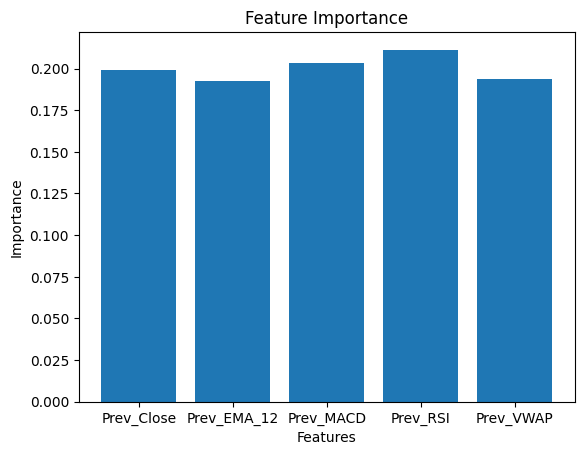

In [6]:
# Step 3: Calculate technical indicators manually

# EMA (Exponential Moving Average)
def calculate_ema(data, period):
    return data['Close'].ewm(span=period, adjust=False).mean()

data['EMA_12'] = calculate_ema(data, 12)
data['EMA_26'] = calculate_ema(data, 26)

# MACD (Moving Average Convergence Divergence)
def calculate_macd(data, fastperiod=12, slowperiod=26, signalperiod=9):
    macd = calculate_ema(data, fastperiod) - calculate_ema(data, slowperiod)
    macd_signal = macd.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

data['MACD'], data['MACD_signal'], data['MACD_hist'] = calculate_macd(data)

# RSI (Relative Strength Index)
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

# VWAP (Volume Weighted Average Price)
def calculate_vwap(data):
    return (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

data['VWAP'] = calculate_vwap(data)

# Step 4: Feature engineering (use previous day's data for prediction)
data['Prev_Close'] = data['Close'].shift(1)
data['Prev_EMA_12'] = data['EMA_12'].shift(1)
data['Prev_MACD'] = data['MACD'].shift(1)
data['Prev_RSI'] = data['RSI'].shift(1)
data['Prev_VWAP'] = data['VWAP'].shift(1)

# Drop any rows with NaN values that were created by the shifts
data = data.dropna()

# Step 5: Create target variable (e.g., predict whether the price will go up or down)
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)  # 1 for up, 0 for down

# Step 6: Define features (X) and target (y)
X = data[['Prev_Close', 'Prev_EMA_12', 'Prev_MACD', 'Prev_RSI', 'Prev_VWAP']]
y = data['Target']

# Step 7: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Build and train the machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 10: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Optional: Plot the feature importances
feature_importances = model.feature_importances_
features = X.columns

plt.bar(features, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
